# Building an Estimator

Once we have our data in the "right" format (i.e. files containing
`tf.train.Example` protocol buffers), Tensorflow makes the actual
ML part straightforward.

In this notebook we will first set up the computational graph that
reads the input data and transforms it into tensors, and then use
Tensorflow's "canned" estimator to learn from there.

This notebook contains a whole series of exciting bonus sections
that you certainly won't have time to solve during the workshop,
but you might want to come back to these after the workshop to create
more sophisticated models that solve the task better.

In [1]:
from __future__ import division, print_function

import itertools
import numpy as np
import tensorflow as tf
from matplotlib import pyplot

!mkdir -p _derived  # (Needed for running in Colab environment.)
%matplotlib inline
# Always make sure you are using running the expected version.
# There are considerable differences between versions...
# Tested with 1.4.1 and 1.7.0
tf.__version__

'1.7.0'

# 1 Reading the data

In [2]:
# Load data generated in 1_qd_data:
data_path = '../data/dataset_img'
# Show files in dataset.
!ls -lh $data_path

total 747016
-rw-r--r--  1 andreassteiner  staff   5.2M May 19 17:27 eval-00000-of-00010
-rw-r--r--  1 andreassteiner  staff   5.2M May 19 17:27 eval-00001-of-00010
-rw-r--r--  1 andreassteiner  staff   5.2M May 19 17:27 eval-00002-of-00010
-rw-r--r--  1 andreassteiner  staff   5.2M May 19 17:27 eval-00003-of-00010
-rw-r--r--  1 andreassteiner  staff   5.2M May 19 17:27 eval-00004-of-00010
-rw-r--r--  1 andreassteiner  staff   5.2M May 19 17:27 eval-00005-of-00010
-rw-r--r--  1 andreassteiner  staff   5.2M May 19 17:27 eval-00006-of-00010
-rw-r--r--  1 andreassteiner  staff   5.2M May 19 17:27 eval-00007-of-00010
-rw-r--r--  1 andreassteiner  staff   5.2M May 19 17:27 eval-00008-of-00010
-rw-r--r--  1 andreassteiner  staff   5.2M May 19 17:27 eval-00009-of-00010
-rw-r--r--  1 andreassteiner  staff    74B May 19 17:27 labels.txt
-rw-r--r--  1 andreassteiner  staff   5.2M May 19 17:27 test-00000-of-00010
-rw-r--r--  1 andreassteiner  staff   5.2M May 19 17:27 test-00001-of-00010
-rw-r--r

In [3]:
# It's customary to identify the label by an integer number. These
# numbers map to the different classes as follows:
classes = open('%s/labels.txt' % data_path).read().splitlines()
print('%d label classes:\n' % len(classes))
for i, label in enumerate(classes):
    print('%d -> %s' % (i, label))

10 label classes:

0 -> elephant
1 -> giraffe
2 -> kangaroo
3 -> lion
4 -> monkey
5 -> panda
6 -> penguin
7 -> rhinoceros
8 -> tiger
9 -> zebra


## 1.1 Reading the data using pure Python

In [4]:
# Step 1 : Read a single record from the first file.
train_files = tf.gfile.Glob('%s/train-*' % data_path)
record = next(tf.python_io.tf_record_iterator(train_files[0]))
# Step 2 : Parse record into tf.train.Example proto.
example = tf.train.Example.FromString(record)
# We need the image "img_64" and the "label". Both are of type
# int64_list: the label is stored by its index and the image is
# a 64x64 list of integers that are the pixel values.
for name, feature in example.features.feature.items():
    print('%20s (%s)' % (name, feature.WhichOneof('kind')))

              img_64 (int64_list)
         countrycode (bytes_list)
               label (int64_list)
                word (bytes_list)
           timestamp (int64_list)
              key_id (int64_list)
          recognized (int64_list)


In [5]:
# Step 3 : Read features.
img_64 = example.features.feature['img_64'].int64_list.value
img_64 = np.array(img_64).reshape((64, 64)) / 255.
label = example.features.feature['label'].int64_list.value[0]

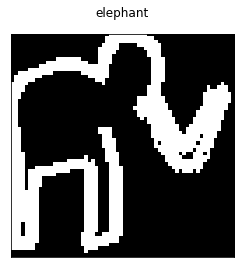

In [6]:
# Visualize drawing.

def show_img(img_64, title, ax=None):
    (ax if ax else pyplot).matshow(img_64, cmap='gray')
    ax = ax if ax else pyplot.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

show_img(img_64, classes[label])

## 1.2 Reading the data using Tensorflow

In [7]:
%%writefile _derived/4_input_fn_img.py
# (Written into separate file for sharing with cloud code.)

# Read input data from sharded files using 1.4 API.
# This is copied and slightly simplified from tf_snippets.ipynb

# Note that this cell simply defines the functions but does not yet call
# them. The functions are executed in the next cell within a tf.Graph()
# context.

# This dictionary specifies what "features" we want to extract from the
# tf.train.Example protos (i.e. what they look like on disk). We only
# need the image data "img_64" and the "label". Both features are tensors
# with a fixed length.
# You need to specify the correct "shape" and "dtype" parameters for
# these features...
feature_spec = {
    # Single label per example => shape=[1] (we could also use shape=() and
    # then do a transformation in the input_fn).
    'label': tf.FixedLenFeature(shape=[1], dtype=tf.int64),
    # The bytes_list data is parsed into tf.string.
    'img_64': tf.FixedLenFeature(shape=[64, 64], dtype=tf.int64),
}

def parse_example(serialized_example):
    # Convert string to tf.train.Example and then extract features/label.
    features = tf.parse_single_example(serialized_example, feature_spec)
    # Important step: remove "label" from features!
    # Otherwise our classifier would simply learn to predict
    # label=features['label']...
    label = features.pop('label')
    # Convert int64 [0..255] to float [0..1]
    features['img_64'] = tf.cast(features['img_64'], tf.float32) / 255.
    return features, label

# Common Tensorflow pattern : wrap function to specify parameters.
# The estimator interface expects a "input_fn" as a parameter, and not the
# tensors (features, labels) so it can re-create the tensors in different
# graphs later on.
def make_input_fn(files_pattern, batch_size=100):
    def input_fn():
        # Signature input_fn: () -> features=Dict[str, Tensor], labels=Tensor
        ds = tf.data.TFRecordDataset(tf.gfile.Glob(files_pattern))
        ds = ds.map(parse_example).batch(batch_size)
        ds = ds.shuffle(buffer_size=5*batch_size).repeat()
        features, labels = ds.make_one_shot_iterator().get_next()
        return features, labels
    return input_fn

Overwriting _derived/4_input_fn_img.py


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


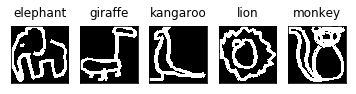

In [8]:
# Define a graph, load a batch of examples and display one of them.

%run -i _derived/4_input_fn_img.py

# First, we create the input_fn -- this defines which files to read from
# and the batch size, and can later be passed around.
batch_size = 5
input_fn = make_input_fn(files_pattern='%s/train-*' % data_path,
                         batch_size=batch_size)
with tf.Graph().as_default():
    # After registering a default graph, we call the previously defined
    # input_fn.
    # This yields the dictionary of feature tensors and the label tensor.
    features, labels = input_fn()
    with tf.train.MonitoredSession() as sess:
        # Note: We create a tf.train.MonitoredSession instead of a normal
        # tf.Session because Tensorflow is using pipelines under the hood
        # to read data in a streaming fashion from disk into our computational
        # Graph. If we used a plain old tf.Session(), then we would have to
        # take care of initializing the threads for the pipelines ourselves...
        img_64_, labels_ = sess.run([features['img_64'], labels])
        # Note that first dimension is the batch dimension.
        for i in range(batch_size):
            ax = pyplot.subplot(1, batch_size, i+1)
            show_img(img_64_[i], classes[labels_[i][0]], ax)

# Also note how content changes upon every re-execution of this cell.
# That is because of the randomization in the input_fn.

# 2 Canned estimators

Once we have our `input_fn`, it's a piece of cake to do some
machine learning on top of it using Tensorflow's "canned
estimators". Let's start with a simple
[LinearClassifier](https://www.tensorflow.org/versions/master/api_docs/python/tf/estimator/LinearClassifier).

A LinearClassifier implements simple **logistic regression** that is basically
a neural network where every input neuron (pixel image) is directly connected
to all output neurons (probabilities for different classes). Every output neuron
effectively remembers a "mask" in the input pixel space, an approach that
quickly learns to identify drawings that have similar pixel activations, but
fails to learn anything more complicated (e.g. an elephant's trunk could
activate the giraffe's "neck mask" if it happened to be in the same pixel
region).

In [9]:
# "Feature columns" tell our canned estimator how to make use of the
# data returned by input_fn(). In our case we have a single feature that
# is of numerical (defaults to tf.float32) type with shape=(64, 64).
feature_columns = [
    # Add a feature column of numeric type and correct shape for the "img_64" feature.
    tf.feature_column.numeric_column('img_64', shape=(64, 64))
]

# Note that feature columns can also be used to generate the "feature_spec"
# used to parsing the tf.train.Example protocol buffers, and that there are
# other feature column types that can do complicated data transformation
# (such as looking up strings and creating embeddings) -- but that's a story
# for another workshop ;-)

# (we also need to specify number of output classes)
linear_estimator  = tf.estimator.LinearClassifier(feature_columns=feature_columns,
                                                  n_classes=len(classes))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpdrkyvww1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x181899da58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:
# Connect it to the input_fn with the training data and train the classifier.

### YOUR ACTION REQUIRED:
# You have to specify what data to use for training (which input_fn), and how
# many steps you want to train for. The number of examples used for training is
# = steps * batch_size.
input_fn = make_input_fn('%s/train-*' % data_path) #input_fn = make_input_fn(...)

### YOUR ACTION REQUIRED:
# Try different number of training steps and see how this influences training time
# (and accuracy in cell below). Note that you have to re-run the previous cell
# to "reset" the classifier (otherwise the estimator will simply *continue* the
# training with an additional number of steps).
steps = 300 #steps =
linear_estimator.train(input_fn=input_fn, steps=steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpdrkyvww1/model.ckpt.
INFO:tensorflow:loss = 230.259, step = 1
INFO:tensorflow:global_step/sec: 304.281
INFO:tensorflow:loss = 1568.44, step = 101 (0.328 sec)
INFO:tensorflow:global_step/sec: 369.705
INFO:tensorflow:loss = 771.611, step = 201 (0.271 sec)
INFO:tensorflow:Saving checkpoints for 300 into /var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpdrkyvww1/model.ckpt.
INFO:tensorflow:Loss for final step: 637.073.


In [11]:
# Evaluate the fitted classifier.
### YOUR ACTION REQUIRED:
# Find the correct values for below variables. Note that you should *not*
# evaluate with the same data used for training.
input_fn = make_input_fn('%s/eval-*' % data_path) #input_fn = 
steps = 100 #steps =
linear_estimator.evaluate(input_fn=input_fn, steps=steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-19-16:21:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpdrkyvww1/model.ckpt-300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2018-05-19-16:21:04
INFO:tensorflow:Saving dict for global step 300: accuracy = 0.5556, average_loss = 5.86927, global_step = 300, loss = 586.927


{'accuracy': 0.55559999,
 'average_loss': 5.8692679,
 'global_step': 300,
 'loss': 586.92682}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpdrkyvww1/model.ckpt-300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


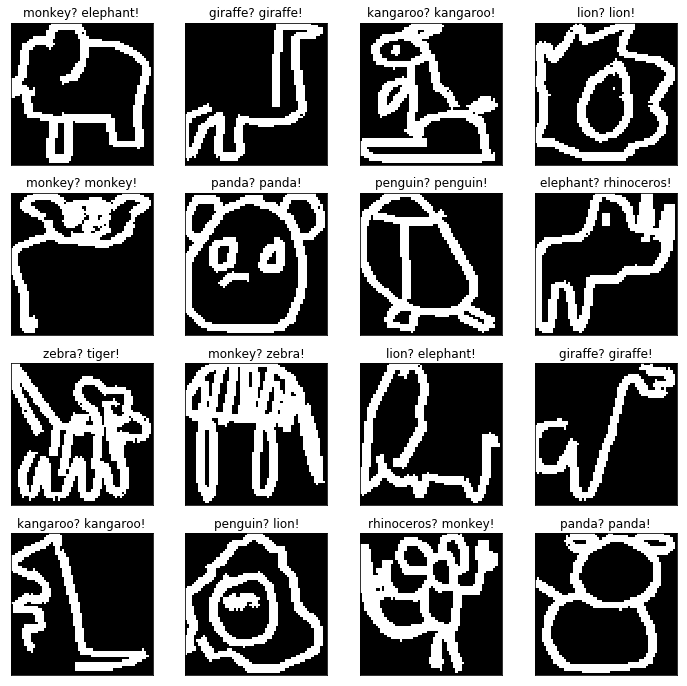

In [12]:
# The simple LinearClassifier does not perform too well... Let's examine
# some classifications so we can see which cases were failing.

# Because estimator.predict() only returns class probabilities and not the
# input data, we parse the features in Python (which gives us a handle on
# the input data) and then create an input_fn using numpy_input_fn().

def get_label_img(files_pattern, n):
    """Reads batch of "img_64" and "label" features.

    Args:
      files_pattern: Pattern matching files containing tf.train.Example.
      n: Number of examples to parse.

    Returns:
      (imgs, labels) with shapes (n, 64, 64) and (n, 1). The image pixel values
      fall in the range 0..1.
    """
    imgs = np.zeros((n, 64, 64), dtype=np.float32)
    labels = np.zeros((n, 1), dtype=np.int64)
    i = 0
    for filename in  tf.gfile.Glob(files_pattern):
        for record in tf.python_io.tf_record_iterator(filename):
            example = tf.train.Example.FromString(record)
            labels[i, 0] = example.features.feature['label'].int64_list.value[0]
            img_64 = example.features.feature['img_64'].int64_list.value
            imgs[i, :, :] = np.array(img_64).reshape((64, 64)) / 255.
            i += 1
            if i >= n:
                return imgs, labels

def show_predictions(estimator, rows=4, cols=4, predict_keys=None):
    """Shows predictions + labels for a couple of examples."""
    # Read data in Python.
    imgs, labels = get_label_img('%s/test-*' % data_path, n=rows*cols)
    # Create input_fn from Python data.
    input_fn = tf.estimator.inputs.numpy_input_fn({'img_64': imgs}, shuffle=False)
    # Get predictions.
    predict_iter = estimator.predict(input_fn=input_fn, predict_keys=predict_keys)
    _, axs = pyplot.subplots(rows, cols, figsize=(cols*3, rows*3))
    for (i, prediction) in enumerate(predict_iter):
        # Plot image, predicted label + correct label.
        predicted = np.argmax(prediction['probabilities'])
        label = labels[i, 0]
        title = '%s? %s!' % (classes[predicted], classes[label])
        ax = axs[i//cols][i%cols]
        show_img(imgs[i], title, ax)
        ax.title.set_position([0.5, 1.0])

show_predictions(linear_estimator)

In [13]:
# Let's use another canned estimator : The "DNNClassifier" (where DNN stands
# for "deep neural network"). Since we're using the same estimator interface,
# we can use the same input_fn() as before.

### YOUR ACTION REQUIRED:
# Try to find a configuration that outperforms our linear classifier.
steps = 3000 #steps = 
hidden_units = [1000] #hidden_units = 

dnn_estimator  = tf.estimator.DNNClassifier(
    hidden_units=hidden_units,
    feature_columns=feature_columns,
    n_classes=len(classes))
dnn_estimator.train(input_fn=make_input_fn('%s/train-*' % data_path),
                    steps=steps)
dnn_estimator.evaluate(input_fn=make_input_fn('%s/eval-*' % data_path),
                       steps=100)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpkb_u5e7c', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1822237da0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/rf/9wzpp24d021fy0p480ggcysm00

{'accuracy': 0.70899999,
 'average_loss': 0.85903329,
 'global_step': 3000,
 'loss': 85.903328}

# 3 Custom convolutional classifier – bonus!<a name="_3 custom convolutional classifier – bonus!"></a><a name="_3 custom convolutional classifier – bonus!"></a>

In the previous section we used a "canned" linear estimator that
computed the predictions from the pixel values directly by logistic
regression.

Of course we know that the pixel values are not randomly distributed,
but actually form a two-dimensional image and we can leverage our
understanding of the data by using
[2D convolutions](https://en.wikipedia.org/wiki/Multidimensional_discrete_convolution).

We will still be using the `tf.estimator` interface, but this time we
specify the computational graph that computes the predictions from the
raw pixel values by hand, using 2D convolutions and max pooling (max pooling
is used to reduce the convoluted image's spatial dimensions).

In [14]:
%%writefile _derived/4_get_logits_img.py
# (Written into separate file for sharing with cloud code.)

# Define a function that computes "logits" from features.
# The "logits" are unbound numbers that will be used as the
# input to the softmax function (which is basically a sigmoid
# function extended to more than two classes). The more positive
# a logit, the closer to one the corresponding probability that
# is the output of the softmax.
# https://en.wikipedia.org/wiki/Softmax_function

def get_logits_img(features, n_classes, mode, params):
    """Computes logits for provided features.

    Args:
      features: A dictionary of tensors that are the features
          and whose first dimension is batch (as returned by input_fn).
      n_classes: Number of classes from which to predict (i.e. the number
          of different values in the "labels" tensor returned by the
          input_fn).
      mode: A tf.estimator.ModeKeys.
      params: Hyper parameters: "convs" specifying the configuration of the
          convolutions, and "hidden" specifying the configuration of the
          dense layers after the convolutions.

    Returns:
      The logits tensor with shape=[batch, n_classes].
    """
    # The parameter "convs" specifies (kernel, stride, filters)
    # of successive convolution layers.
    convs = params.get('convs', ((10, 4, 32), (5, 4, 64)))
    # The parameter "hidden" specifies the number of neurons of
    # successive fully connected layers (after convolution).
    hidden = params.get('hidden', (256,))
    # The function tf.layers.conv2d expects the tensor to have format
    # [batch, height, width, channels] -- since our "img_64" tensor
    # has format [batch, height, width], we need to expand the tensor
    # to get [batch, height, width, channels=1].
    last_layer = tf.expand_dims(features['img_64'], axis=3)
    # We start with dims=width=height=64 and filters=channels=1 and then
    # successively reduce the number of dimensions while increasing the
    # number of filters in every convolutional/maxpooling layer.
    dim = 64
    filters = 1
    for kernel, stride, filters in convs:
        conv = tf.layers.conv2d(
            inputs=last_layer, filters=filters, kernel_size=[kernel, kernel],
            padding='same', activation=tf.nn.relu)
        last_layer = tf.layers.max_pooling2d(
            inputs=conv, pool_size=[stride, stride], strides=stride)
        dim //= stride
    # "Flatten" the last layer to get shape [batch, *]
    last_layer = tf.reshape(last_layer, [-1, filters * dim * dim])
    # Add some fully connected layers.
    for units in hidden:
        dense = tf.layers.dense(inputs=last_layer, units=units,
                                activation=tf.nn.relu)
        # Regularize using dropout.
        training = mode == tf.estimator.ModeKeys.TRAIN
        last_layer = tf.layers.dropout(inputs=dense, rate=0.4,
                                       training=training)
    # Finally return logits that is activation of neurons in last layer.
    return tf.layers.dense(inputs=last_layer, units=n_classes)

Overwriting _derived/4_get_logits_img.py


In [15]:
%%writefile _derived/4_make_model_fn.py
# (Written into separate file for sharing with cloud code.)

# Warning : Boilerplate code cell...

# This cell defines a function that connects the "get_logits_fn"
# to the estimator interface and adds some useful output for our problem.
# By specifying different parameters, the same function can be reused
# in section 5 where we use a recurrent neural network to compute the
# logits.

def make_model_fn(get_logits_fn, n_classes):
    """Creates a model_fn.

    Args:
      get_logits_fn: Function that computes logits from features.
      n_classes: Number of classes.

    Returns:
      A model_fn to be used with an estimator.
    """

    def model_fn(features, labels, mode, params):
        """The model_fn is passed as an argument to the estimator.

        Args:
          features: Dictionary mapping feature names to feature tensors.
          labels: Optional labels (`None` during inference).
          mode: A `tf.estimator.ModeKeys`.
          params: Optional dictionary of hyper parameters.

        Returns:
          A `tf.estimator.EstimatorSpec`.
        """

        # Create logits from features using RNN.
        logits = get_logits_fn(features, n_classes=n_classes, mode=mode,
                               params=params)

        # Convert logits to probabilities.
        probabilities = tf.nn.softmax(logits)
        # Extract class with highest probability.
        predictions = tf.argmax(probabilities, axis=1)

        onehot_labels = loss = train_op = eval_metric_ops = None
        if labels is not None:
            onehot_labels = tf.one_hot(tf.squeeze(labels), n_classes)
            loss = tf.losses.softmax_cross_entropy(onehot_labels, logits)

        if mode == tf.estimator.ModeKeys.TRAIN:
            # Compute loss.
            global_step = tf.train.get_global_step()
            # Minimize.
            train_op = tf.train.AdamOptimizer().minimize(loss, global_step=global_step)
            tf.summary.scalar('loss', loss)
            # Output number of parameters for educational purposes.
            trainable_params = 0
            for var in tf.trainable_variables():
                tf.logging.info('Variable "%s" : %s.', var.name,
                                var.get_shape().as_list())
                trainable_params += np.prod(var.get_shape().as_list())
            tf.logging.info('Total params : %d.', trainable_params)

        if mode == tf.estimator.ModeKeys.EVAL:
            # Report accuracy when evaluating.
            eval_metric_ops = {
                'accuracy': tf.metrics.accuracy(labels, predictions),
            }

        return tf.estimator.EstimatorSpec(
            loss=loss,
            mode=mode,
            predictions={
                'probabilities': probabilities,
                'predictions': predictions,
            },
            export_outputs={
                'prediction': tf.estimator.export.PredictOutput(outputs={
                    'probabilities': probabilities,
                    'predictions': predictions,
                }),
            },
            train_op=train_op,
            eval_metric_ops=eval_metric_ops,
        )

    return model_fn

Overwriting _derived/4_make_model_fn.py


In [16]:
%run -i _derived/4_get_logits_img.py
%run -i _derived/4_make_model_fn.py

# Instead of creating a tf.estimator.LinearClassifier, we now create
# a tf.estimator.Estimator and specify our custom model_fn that will
# be used by the estimator to compute the predictions from the features.
run_config = tf.estimator.RunConfig(save_summary_steps=10)
model_fn = make_model_fn(get_logits_fn=get_logits_img, n_classes=len(classes))
cnn_estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config)
# -- from here on, the code is exactly the same as in the previous section ...

INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpsna0t8j9', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x107e0b780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [17]:
# Note: You can get detailed information about the training by pointing a
# Tensorboard instance to the training directory.
#
# You start Tensorboard via a terminal, for example by clicking on "New"
# -> "Terminal" in the Jupyter directory view (this also works when
# Jupyter server is running inside a Docker image).
#
# The following command will start Tensorboard and show all experimental
# data below the "/tmp" directory (which is where new model directories
# are created if we do not specify a model path):
#
# $ tensorboard --logdir /tmp/
#
# And then view the Tensorboard in your browser:
# http://localhost:6006

# Bonus challenge (don't do this during the workshop) : Try to increase the
# number of training steps, batch_size, and/or parameters (hint: check out
# the "params" argument when creating the estimator in the previous cell)
# -- what accuracy can achieve with this convolutional network?
input_fn = make_input_fn('%s/train-*' % data_path, batch_size=100)
cnn_estimator.train(input_fn=input_fn, steps=100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Variable "conv2d/kernel:0" : [10, 10, 1, 32].
INFO:tensorflow:Variable "conv2d/bias:0" : [32].
INFO:tensorflow:Variable "conv2d_1/kernel:0" : [5, 5, 32, 64].
INFO:tensorflow:Variable "conv2d_1/bias:0" : [64].
INFO:tensorflow:Variable "dense/kernel:0" : [1024, 256].
INFO:tensorflow:Variable "dense/bias:0" : [256].
INFO:tensorflow:Variable "dense_1/kernel:0" : [256, 10].
INFO:tensorflow:Variable "dense_1/bias:0" : [10].
INFO:tensorflow:Total params : 319466.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpsna0t8j9/model.ckpt.
INFO:tensorflow:loss = 2.34815, step = 1
INFO:tensorflow:Saving checkpoints for 100 into /var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpsna0t8j9/model.ckpt.
INFO:

In [18]:
cnn_estimator.evaluate(input_fn=make_input_fn('%s/eval-*' % data_path),
                       steps=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-19-16:24:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpsna0t8j9/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-19-16:24:49
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.75, global_step = 100, loss = 0.931948


{'accuracy': 0.75, 'global_step': 100, 'loss': 0.9319483}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpsna0t8j9/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


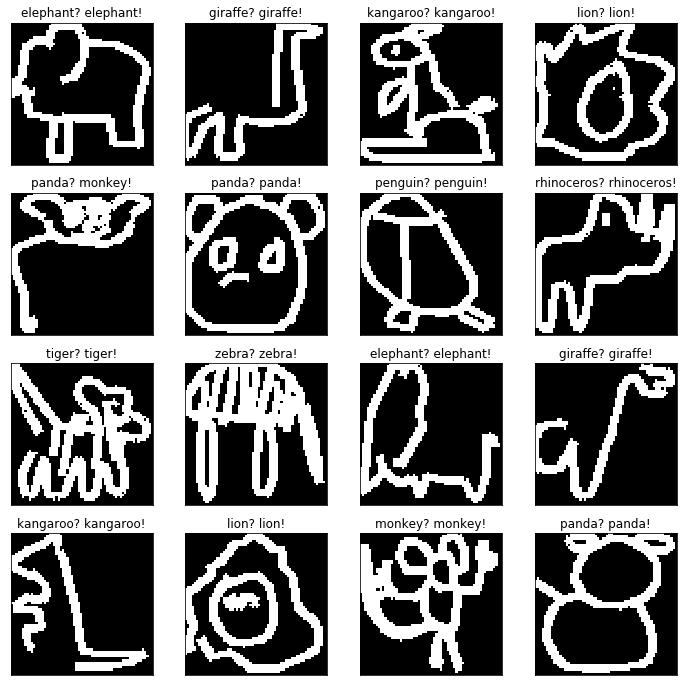

In [19]:
input_fn = make_input_fn('%s/test-*' % data_path, batch_size=1)
show_predictions(cnn_estimator, predict_keys='probabilities')

# 4 Keras – bonus!<a name="_4 keras – bonus!"></a><a name="_4 keras – bonus!"></a>

"Keras is a high-level neural networks API, written in Python and capable of
running on top of TensorFlow, CNTK, or Theano. It was developed with a focus
on enabling fast experimentation. Being able to go from idea to result with
the least possible delay is key to doing good research."
(from https://keras.io/)

In this section we reconstruct the same convolutional model as in the last
section using Keras and then convert the Keras model to an estimator so we
can use the same input functions reading data in a streaming fashion from our
data on disk.

More useful links about Keras (not needed for this section):

- https://keras.io/models/about-keras-models/
- https://keras.io/models/sequential/
- https://keras.io/models/model/
- [Converting Keras model to Tensorflow estimator](https://cloud.google.com/blog/big-data/2017/12/new-in-tensorflow-14-converting-a-keras-model-to-a-tensorflow-estimator)
- [Example using functional API with input_fn](https://github.com/keras-team/keras/blob/master/examples/mnist_tfrecord.py)

In [20]:
# Keras is part of Tensorflow
from tensorflow import keras

# The model is specified as a succession of layers.
# The layers here specify exactly the same model as in the previous section.
model = keras.models.Sequential([
    # Note that we need to name the first layer (to match features, see next
    # cell) and specify the input shape.
    keras.layers.Conv2D(filters=32, kernel_size=10, activation='relu',
                        padding='same', name='firstlayer',
                        input_shape=(64, 64, 1)),
    keras.layers.MaxPooling2D(pool_size=4),
    keras.layers.Conv2D(filters=64, kernel_size=5, activation='relu',
                        padding='same'),
    keras.layers.MaxPooling2D(pool_size=4),
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation='relu'),
    # We also need to name the output layer.
    tf.keras.layers.Dense(units=len(classes), activation='softmax',
                          name='labels'),
])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Neat :-)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
firstlayer (Conv2D)          (None, 64, 64, 32)        3232      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
labels (Dense)               (None, 10)                2570      
Total para

In [21]:
# Helper function to wrap input_fn().
def keras_make_input_fn(*args, **kwargs):
    def wrapper():
        input_fn = make_input_fn(*args, **kwargs)
        features, labels = input_fn()
        # We need to specify which feature is used as the input to
        # which layer. In our case we have a single input feature
        # that is read by layer "firstlayer". Note that we also need
        # to add an additional dimension to get shape=(64, 64, 1).
        features = {
            'firstlayer_input': tf.expand_dims(features['img_64'], axis=3),
        }
        # Labels are expected in one_hot format.
        labels = tf.one_hot(tf.squeeze(labels), 10)
        return features, labels
    return wrapper

# From now on we proceed exactly as before...
keras_estimator = keras.estimator.model_to_estimator(model)
input_fn = keras_make_input_fn('%s/train-*' % data_path, batch_size=100)
keras_estimator.train(input_fn=input_fn, steps=100)

INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpq3of6wz3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1821fcc978>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpq3of6wz3/keras_model.ckpt
INF

In [22]:
keras_estimator.evaluate(input_fn=keras_make_input_fn('%s/eval-*' % data_path),
                         steps=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-19-16:26:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpq3of6wz3/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-19-16:26:14
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.76, global_step = 100, loss = 0.676807


{'accuracy': 0.75999999, 'global_step': 100, 'loss': 0.67680681}

# 5 Recurrent neural network – bonus!

So far we have been processing two dimensional image data. That
data can be converted nicely into a dense tensor that is then the
input layer of a linear classifier or convolutional network.

If we want to process the raw stroke data, we need a different
network architecture that reads in coordinate by coordinate, while
updating its internal state and finally outputs a prediction --
a **recurrent network**.

Explaining the architecture for recurrent networks (specifically,
we use a LSTM in this section) is out of the scope of this workshop,
please read the following articles if you want to know more about the
architecture:

- http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/

Using recurrent networks requires some tensor shape black magic and
this is the main focus of this section.

In [23]:
# Load stroke data generated in 1_qd_data (bonus section):
stroke_data_path = '../data/dataset_stroke'
!ls -lh $stroke_data_path

total 1394336
-rw-r--r--  1 andreassteiner  staff   9.7M May 19 17:31 eval-00000-of-00010
-rw-r--r--  1 andreassteiner  staff   9.7M May 19 17:31 eval-00001-of-00010
-rw-r--r--  1 andreassteiner  staff   9.7M May 19 17:31 eval-00002-of-00010
-rw-r--r--  1 andreassteiner  staff   9.7M May 19 17:31 eval-00003-of-00010
-rw-r--r--  1 andreassteiner  staff   9.8M May 19 17:31 eval-00004-of-00010
-rw-r--r--  1 andreassteiner  staff   9.7M May 19 17:31 eval-00005-of-00010
-rw-r--r--  1 andreassteiner  staff   9.7M May 19 17:31 eval-00006-of-00010
-rw-r--r--  1 andreassteiner  staff   9.7M May 19 17:31 eval-00007-of-00010
-rw-r--r--  1 andreassteiner  staff   9.8M May 19 17:31 eval-00008-of-00010
-rw-r--r--  1 andreassteiner  staff   9.7M May 19 17:31 eval-00009-of-00010
-rw-r--r--  1 andreassteiner  staff    74B May 19 17:31 labels.txt
-rw-r--r--  1 andreassteiner  staff   9.7M May 19 17:31 test-00000-of-00010
-rw-r--r--  1 andreassteiner  staff   9.7M May 19 17:31 test-00001-of-00010
-rw-r--

In [24]:
# Label classes...
classes = open('%s/labels.txt' % stroke_data_path).read().splitlines()
print('%d label classes:\n' % len(classes))
for i, label in enumerate(classes):
    print('%d -> %s' % (i, label))

10 label classes:

0 -> elephant
1 -> giraffe
2 -> kangaroo
3 -> lion
4 -> monkey
5 -> panda
6 -> penguin
7 -> rhinoceros
8 -> tiger
9 -> zebra


In [25]:
# Some remarks on "sparse tensors": Conceptually, these
# tensors are an efficient representation of a tensor that
# has mostly "0" values. In the example below we initialize
# a sparse tensor by specifying only non-"0" values and then
# print the tensor as well as its dense representation.

# If we read "variable length" tensors from disk then these
# tensors will also be represented as sparse tensors (although
# the tensors might be "dense" in a sense that they have very
# few "0" values).

with tf.Graph().as_default():
    # Only specify non-"0" values of 3x3 diagnal matrix.
    sparse = tf.SparseTensor(indices=[[0, 0], [1, 1], [2, 2]], values=[1, 2, 3],
                             dense_shape=[3, 3])
    # Convert to dense representation. Note that we can specify any
    # "dense_shape" (resulting dense tensor is zero padded).
    dense = tf.sparse_to_dense(sparse.indices, sparse.dense_shape,
                               sparse.values)
    with tf.Session() as sess:
        print(sparse.eval())
        print(dense.eval())

SparseTensorValue(indices=array([[0, 0],
       [1, 1],
       [2, 2]]), values=array([1, 2, 3], dtype=int32), dense_shape=array([3, 3]))
[[1 0 0]
 [0 2 0]
 [0 0 3]]


In [26]:
%%writefile _derived/4_convert_sparse.py
# (Written into separate file for sharing with cloud code.)

# Now let's define a helper function that limits variable length
# sparse tensors to a maximum length and converts them to dense
# tensors. We need to convert sparse tensors to dense tensors before
# we can use them as input in the recurrent neural network.

def convert_sparse(sparse, max_len):
    """Converts batched sparse tensor to dense tensor with specified size.
    
    Args:
      sparse: tf.SparseTensor instance of shape=[n].
      max_len: Truncates / zero-pads the dense tensor the specified max_len.
    """
    # Convert to dense tensor.
    dense = tf.sparse_to_dense(sparse.indices, sparse.dense_shape,
                               sparse.values)
    # Discard values above max_len.
    dense = dense[:max_len]
    # Zero-pad if length < max_len.
    dense = tf.pad(dense, [[0, max_len - tf.shape(dense)[0]]])
    return dense

Overwriting _derived/4_convert_sparse.py


In [27]:
%run -i _derived/4_convert_sparse.py

with tf.Graph().as_default():
    # Manually define sparse X-coordinates [1,2,3,4,5].
    # Note that our stroke coordinate "sparse tensors" have a single dimension
    # and do not contain any zeros at all...
    stroke_x = tf.SparseTensor(
        indices=[[0], [1], [2], [3], [4]],
        values=[1, 2, 3, 4, 5],
        dense_shape=[5])
    # Extract both shorter and longer dense tensor.
    dense_short = convert_sparse(stroke_x, max_len=3)
    dense_long = convert_sparse(stroke_x, max_len=10)
    with tf.Session() as sess:
        print(dense_short.eval())
        print(dense_long.eval())

[1 2 3]
[1 2 3 4 5 0 0 0 0 0]


In [28]:
%%writefile _derived/4_input_fn_stroke.py
# (Written into separate file for sharing with cloud code.)

# Because the data is stored in a different format (strokes instead of pixels)
# we need a new input_fn.

# Maximum number of points in concatenated strokes.
MAX_LEN = 256

# Because every drawing has a different number of points, we use "VarLenFeature"
# and not "FixedLenFeature" for the stroke data. This will create
# "SparseTensor".
feature_spec = {
    'stroke_x': tf.VarLenFeature(dtype=tf.float32),
    'stroke_y': tf.VarLenFeature(dtype=tf.float32),
    'stroke_z': tf.VarLenFeature(dtype=tf.float32),
    'stroke_len': tf.FixedLenFeature([], tf.int64),
    'label': tf.FixedLenFeature([], tf.int64),
}

def parse_example_stroke(serialized_example):
    features = tf.parse_single_example(serialized_example, feature_spec)
    label = features.pop('label')

    # The we create a 'stroke' tensor with shape [3, MAX_LEN] where the first
    # dimension indicates whether the values are X, Y, or Z coordinates.
    stroke = tf.stack([
        convert_sparse(features['stroke_x'], max_len=MAX_LEN),
        convert_sparse(features['stroke_y'], max_len=MAX_LEN),
        convert_sparse(features['stroke_z'], max_len=MAX_LEN),
    ])

    # Also truncate the "stroke_len" to MAX_LEN if needed.
    stroke_len = tf.minimum(tf.cast(MAX_LEN, tf.int64), features['stroke_len'])

    return dict(stroke=stroke, stroke_len=stroke_len), label

# Copied from above Section "1.2 Reading the data using Tensorflow"
def make_input_fn_stroke(files_pattern, batch_size=100):
    def input_fn():
        dataset = tf.data.TFRecordDataset(tf.gfile.Glob(files_pattern))
        dataset = dataset.map(parse_example_stroke).batch(batch_size)
        dataset = dataset.shuffle(buffer_size=5*batch_size).repeat()
        features, labels = dataset.make_one_shot_iterator().get_next()
        return features, labels
    return input_fn

Overwriting _derived/4_input_fn_stroke.py


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


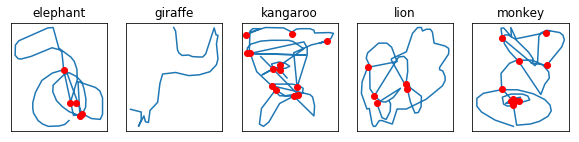

In [29]:
# Read some examples with above input_fn and plot data.

%run -i _derived/4_input_fn_stroke.py

# (Modified code from section 1.1 and 1.2)

def show_stroke_img(stroke, label, ax=None):
    """Plots stroke data.

    Args:
      stroke: Array of shape=[3, n] where the second dimension
          is time and the first dimension indicates X/Y coordinates
          and Z-dimension that is set to 1 when a stroke ends and
          0 otherwise (the array actually represents an array of
          concatenated strokes and the Z-dimension is needed to tell
          the individual strokes apart).
    """
    ax = ax if ax else pyplot.gca()
    xy = stroke[:2, :].cumsum(axis=1)
    ax.plot(*xy)
    # Plot all the strokes, including connecting line between strokes.
    pxy = xy[:, stroke[2] != 0]
    # Red dots mark end of individual strokes.
    ax.plot(pxy[0], pxy[1], 'ro')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(label)

batch_size = 5
input_fn = make_input_fn_stroke(files_pattern='%s/train-*' % stroke_data_path,
                                batch_size=batch_size)
with tf.Graph().as_default():
    features, labels = input_fn()
    with tf.train.MonitoredSession() as sess:
        strokes_, labels_ = sess.run([features['stroke'], labels])
        pyplot.figure(figsize=(10, 2))
        for i in range(batch_size):
            ax = pyplot.subplot(1, batch_size, i+1)
            show_stroke_img(strokes_[i], classes[labels_[i]], ax)

In [30]:
%%writefile _derived/4_get_nth.py
# (Written into separate file for sharing with cloud code.)

# Another helper function: This function will return the "nth element"
# with different "n" for every element in the batch.
# We will later need this function to get the prediction in the output
# of the dynamic_rnn.

def get_nth(tensor, ns, last_dim):
    """Tensor has shape [batch_size, max_len, last_dim]."""
    shape = tf.shape(tensor)
    batch_size, max_len = shape[0], shape[1]
    # Flatten first two dimensions.
    tensor = tf.reshape(tensor, [-1, last_dim])
    # Calculate indices within flattened tensor.
    idxs = tf.range(0, batch_size) * max_len + (tf.cast(ns, tf.int32) - 1)
    # Return nth elements.
    # TODO get rid of error UserWarning : https://stackoverflow.com/questions/35892412
    return tf.gather(tensor, idxs)

Overwriting _derived/4_get_nth.py


In [31]:
%run -i _derived/4_get_nth.py

with tf.Graph().as_default(), tf.Session(graph=tf.Graph()) as sess:
    # Define a batch with shape=[batch_size=2, max_len=5, last_dim=2]
    batch = tf.constant([
        # First tensor in batch (shape=[5, 2])
        [[1, 1], [2, 2], [3, 3], [4, 4], [5, 5]],
        # Second tensor in batch (shape=[5, 2])
        [[-1, -1], [-2, -2], [-3, -3], [-4, -4], [-5, -5]],
    ])
    # Return the second and third element.
    lens = tf.constant([2, 3], dtype=tf.int64)
    print(get_nth(batch, lens, last_dim=2).eval())

[[ 2  2]
 [-3 -3]]


In [32]:
%%writefile _derived/4_get_logits_stroke.py
# (Written into separate file for sharing with cloud code.)

# This function creates creates the logits fro the stroke features.
def get_logits_stroke(features, n_classes, mode, params):
    """Computes logits for provided features.

    Args:
      features: A dictionary of tensors that are the features
          and whose first dimension is batch (as returned by input_fn).
      n_classes: Number of classes from which to predict (i.e. the number
          of different values in the "labels" tensor returned by the
          input_fn).
      mode: A tf.estimator.ModeKeys.
      params: Hyper parameters: "cell_size" specifying the state size of
          the LSTM cells, and "hidden" specifying the configuration of the
          dense layers after recurrent network.

    Returns:
      The logits tensor with shape=[batch, n_classes].
    """

    cell_size = params.get('cell_size', 256)
    hidden = params.get('hidden', ())
    
    # First we convert our data from "coords major" to "time major",
    # as required by the dynamic_rnn API.
    # [batch, coords, time] -> [batch, time, coords]
    stroke = tf.transpose(features['stroke'], perm=[0, 2, 1])
    stroke_len = features['stroke_len']

    # Construct a bi-directional dynamic recurrent NN with LSTM
    # cells.
    outputs, states = tf.nn.bidirectional_dynamic_rnn(
            cell_fw=tf.nn.rnn_cell.LSTMCell(cell_size),
            cell_bw=tf.nn.rnn_cell.LSTMCell(cell_size),
            inputs=stroke,
            sequence_length=stroke_len,
            dtype=tf.float32,
    )
    # Use helper function from last cell to extract RNN output values.
    outputs = tf.concat((get_nth(outputs[0], stroke_len, last_dim=cell_size),
                         get_nth(outputs[1], stroke_len, last_dim=cell_size)),
                        axis=1)

    # Add fully connected layers on top.
    for units in hidden:
        outputs = tf.layers.dense(inputs=outputs, units=units,
                                  activation=tf.nn.relu)

    # Logits are activations of last fully connected layer.
    return tf.layers.dense(inputs=outputs, units=n_classes)

Overwriting _derived/4_get_logits_stroke.py


In [33]:
%run -i _derived/4_get_logits_stroke.py

# Same as before : Create estimator, train, evaluate.
# Note that we need *much* more time and/or CPU power to get
# decent results with the RNN, but eventually it will outperform
# the convolutional classifier...

# Use make_model_fn from section "3 Custom convolutional classifier"
model_fn = make_model_fn(get_logits_fn=get_logits_stroke, n_classes=len(classes))
config = tf.estimator.RunConfig(save_summary_steps=1)
rnn_estimator = tf.estimator.Estimator(model_fn=model_fn, config=config)

# We use smaller batch size to keep memory usage below ~1G (the
# RNN has a large memory footprint because of the temporal unrolling).
# To get good performance with this type of network we need much longer
# training, which is impractical in a notebook. See next notebook
# "5_qd_cloud" that describes how to train the network on Google Cloud
# Environment using Cloud ML...
input_fn = make_input_fn_stroke('%s/train-*' % stroke_data_path, batch_size=10)
rnn_estimator.train(input_fn=input_fn, steps=100)
input_fn = make_input_fn_stroke('%s/eval-*' % stroke_data_path, batch_size=10)
rnn_estimator.evaluate(input_fn=input_fn, steps=10)

INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpndl3kyyq', '_tf_random_seed': None, '_save_summary_steps': 1, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1822c94e48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.


/Users/andreassteiner/miniconda2/envs/bob_py3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Variable "bidirectional_rnn/fw/lstm_cell/kernel:0" : [259, 1024].
INFO:tensorflow:Variable "bidirectional_rnn/fw/lstm_cell/bias:0" : [1024].
INFO:tensorflow:Variable "bidirectional_rnn/bw/lstm_cell/kernel:0" : [259, 1024].
INFO:tensorflow:Variable "bidirectional_rnn/bw/lstm_cell/bias:0" : [1024].
INFO:tensorflow:Variable "dense/kernel:0" : [512, 10].
INFO:tensorflow:Variable "dense/bias:0" : [10].
INFO:tensorflow:Total params : 537610.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpndl3kyyq/model.ckpt.
INFO:tensorflow:loss = 2.30219, step = 1
INFO:tensorflow:Saving checkpoints for 100 into /var/folders/rf/9wzpp24d021fy0p480ggcysm0000gn/T/tmpndl3kyyq/model.ckpt.
INFO:tensorflow:Loss for final step: 2.39157.
INFO:tensorflo

{'accuracy': 0.18000001, 'global_step': 100, 'loss': 2.2413225}

# A References

- https://www.tensorflow.org/versions/master/get_started/feature_columns
- https://arxiv.org/abs/1704.03477 : A Neural Representation of Sketch Drawings
- https://cloud.google.com/blog/big-data/2017/01/learn-tensorflow-and-deep-learning-without-a-phd : Nice tutorial explaining convolutions, recurrent networks, and some deep learning tricks – Challenge: try to improve the models in this notebook with the techniques described in this presentation!